##  Clustering
We explore different clustering algorithms to use on a dataset of music features. Part I involves using all data, while Part II involves using only data from a specific genre.

In [ ]:
%matplotlib inline

import ast
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.cluster import MeanShift, KMeans, AffinityPropagation, AgglomerativeClustering, FeatureAgglomeration, SpectralClustering, estimate_bandwidth
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, v_measure_score
from sklearn import cluster

### Pre-Processing
Before feeding track data into clustering algorithms, I'll first:
- Absorb genres that have instances that don't meet a certain cutoff, "minor genres", into bigger genres "major genres".  
- Scale the tempo column, which is currently in BPM, to a scale from 0-1.0.


In [ ]:
tracks = pd.read_csv('filtered.csv', index_col=0)

tracks.dropna(inplace=True)
audio_cols = ['track_acousticness', 'track_danceability', 'track_energy', 'track_instrumentalness', 'track_liveness', 'track_speechiness', 'track_tempo', 'track_valence']
tracks.head()



,track_title,album_date_released,album_listens,album_favorites,artist_favorites,track_genretop,track_favorites,track_listens,track_interest,track_acousticness,track_danceability,track_energy,track_instrumentalness,track_liveness,track_speechiness,track_tempo,track_valence
track_id,,,,,,,,,,,,,,,,,
1,Food,1/5/2009 0:00,6073,4.0,9.0,Hip-Hop,2,1293,4656,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
2,Electric Ave,1/5/2009 0:00,6073,4.0,9.0,Hip-Hop,1,514,1470,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
3,This World,1/5/2009 0:00,6073,4.0,9.0,Hip-Hop,6,1151,1933,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
4,Freeway,2/6/2008 0:00,47632,4.0,74.0,Pop,178,50135,54881,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
5,Street Music,1/5/2009 0:00,6073,4.0,9.0,Hip-Hop,3,943,1126,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


#### Distribution of audio features 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f647c82a150>,
      dtype=object)

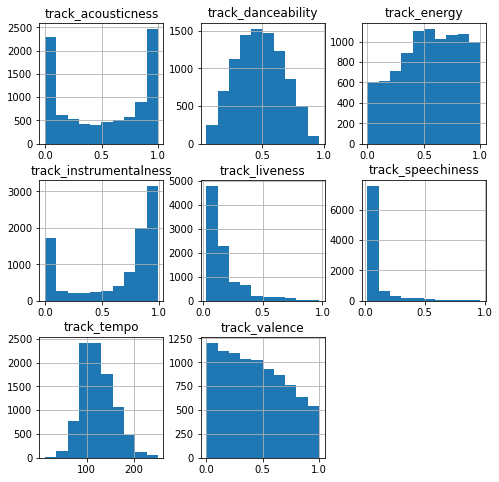

In [ ]:
X_prenorm = tracks[audio_cols]
pd.DataFrame(X_prenorm,columns=audio_cols).hist(figsize=(8,8))


In [ ]:
genre_count = tracks.groupby('track_genretop').agg({'track_genretop':'count'})['track_genretop']
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values
print(genre_count)
print("Major genres: {} \nMinor Genres: {}".format(major_genres, minor_genres))

track_genretop
Blues                    47
Classical                71
Country                   9
Electronic             1010
Experimental            173
Folk                    458
Hip-Hop                 319
Instrumental             48
International           110
Jazz                    178
Old-Time / Historic     124
Pop                     188
Rock                   2272
Soul-RnB                  1
Spoken                   15
Name: track_genretop, dtype: int64
Major genres: ['Electronic' 'Folk' 'Hip-Hop' 'Rock'] 
Minor Genres: ['Blues' 'Classical' 'Country' 'Experimental' 'Instrumental'
 'International' 'Jazz' 'Old-Time / Historic' 'Pop' 'Soul-RnB' 'Spoken']


In [ ]:
### method: Merge nearest genres
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values

# Scale Tempo
tempo = tracks['track_tempo'].values.reshape(-1,1)
tracks['track_tempo'] = MinMaxScaler().fit_transform(tempo)

# Normalize audio columns
norm = Normalizer()
tracks[audio_cols] = norm.fit_transform(tracks[audio_cols])

# Group By Mean
genre_groupby = tracks.groupby('track_genretop').agg('mean')
clusters = genre_groupby.reset_index().rename({'track_genretop':'cluster'}, axis=1)
#clusters['method'] = 'Mean'

minor_clusters = clusters.loc[clusters.cluster.isin(minor_genres)]
major_clusters =  clusters.loc[clusters.cluster.isin(major_genres)]

new_genres = dict(zip(major_genres,major_genres))

for i, r in minor_clusters.iterrows():
    genre = r[0]
    genre_coordinates = r[1:9].values
    genre_coordinates_other = major_clusters[audio_cols].values

    # Calculate distances between each genre; choose closest genre as the one with minimum distance
    distances = [abs(np.linalg.norm(genre_coordinates-c)) for c in genre_coordinates_other]
    min_distance = min(distances)
    closest_genre = major_genres[distances.index(min_distance)]
    print("minor genre: {}, closest major genre: {}".format(genre, closest_genre))

    # Reassign genre values for largely minority genres
    tracks['track_genretop'].loc[tracks['track_genretop']==genre] = closest_genre
    new_genres[closest_genre] = new_genres[closest_genre] + "/" + genre

tracks = tracks.replace(new_genres)
print(tracks.groupby('track_genretop').agg({'track_genretop':'count'})['track_genretop'])

minor genre: Blues, closest major genre: Hip-Hop
minor genre: Classical, closest major genre: Hip-Hop
minor genre: Country, closest major genre: Hip-Hop
minor genre: Experimental, closest major genre: Hip-Hop
minor genre: Instrumental, closest major genre: Hip-Hop
minor genre: International, closest major genre: Hip-Hop
minor genre: Jazz, closest major genre: Hip-Hop
minor genre: Old-Time / Historic, closest major genre: Folk
minor genre: Pop, closest major genre: Hip-Hop
minor genre: Soul-RnB, closest major genre: Hip-Hop
minor genre: Spoken, closest major genre: Hip-Hop
track_genretop
Electronic                                                                                          1010
Folk/Old-Time / Historic                                                                             582
Hip-Hop/Blues/Classical/Country/Experimental/Instrumental/International/Jazz/Pop/Soul-RnB/Spoken    1159
Rock                                                                                       

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
genre_groupby = tracks.groupby('track_genretop').agg('mean')
clusters = genre_groupby.reset_index().rename({'track_genretop':'cluster'}, axis=1)
clusters['method'] = 'Mean'

clusters

,cluster,album_favorites,artist_favorites,track_acousticness,track_danceability,track_energy,track_instrumentalness,track_liveness,track_speechiness,track_tempo,track_valence,method
0,Electronic,1.202970,12.452475,0.264434,0.371218,0.387591,0.503960,0.119479,0.085856,0.304250,0.282764,Mean
1,Folk/Old-Time / Historic,1.836770,31.682131,0.573208,0.295423,0.169271,0.493797,0.133633,0.058442,0.277084,0.242821,Mean
2,Hip-Hop/Blues/Classical/Country/Experimental/I...,1.942192,20.035375,0.405500,0.355849,0.319886,0.405352,0.124633,0.087715,0.299543,0.319213,Mean
3,Rock,1.128081,11.189261,0.407065,0.277653,0.392909,0.465912,0.122006,0.057073,0.318824,0.285155,Mean


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6473751550>,
      dtype=object)

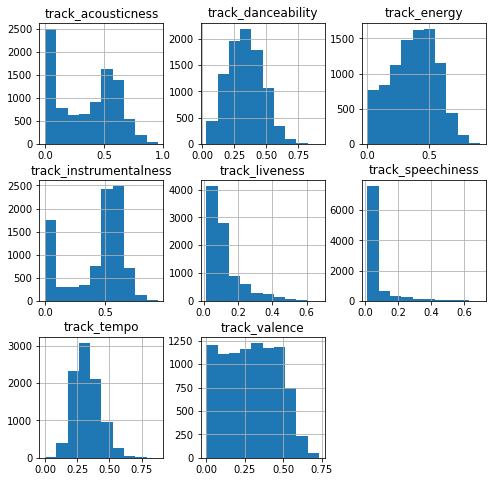

In [ ]:
tracks[audio_cols].hist(figsize=(8,8))

### Clustering on all genres: Preliminary Machine Learning

### Finding appropriate K-Values
#### Elbow Method

Text(0.5, 1.0, 'Elbow Method')

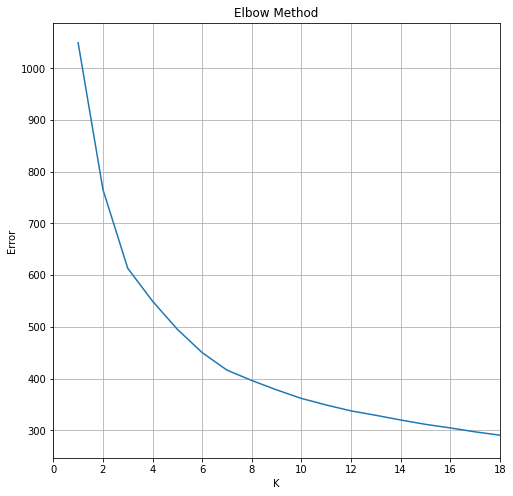

In [ ]:
X = tracks[['track_acousticness', 'track_danceability', 'track_energy', 'track_instrumentalness', 'track_liveness', 'track_speechiness', 'track_tempo', 'track_valence']]

Ks = np.arange(1, 20)
km = [KMeans(n_clusters=i, random_state=1986) for i in Ks]
score = [-km[i].fit(X).score(X) for i in range(len(km))]
Ks.dtype = int
plt.figure(figsize=(8,8))
plt.plot(Ks,score)
plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Elbow Method')

#### Silhouette Scores

Text(0.5, 1.0, 'Silhouette Scores')

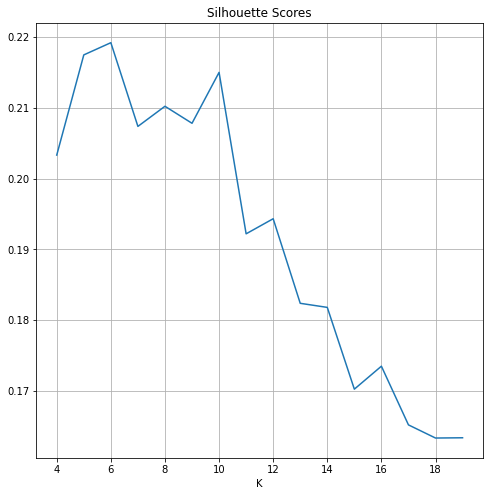

In [ ]:
Ks = np.arange(2, 20)
kms = [KMeans(n_clusters=i, random_state=1986).fit(X) for i in Ks]
s_scores = [silhouette_score(X,kms[i].labels_) for i in range(2,len(Ks))]
plt.figure(figsize=(8,8))
plt.plot(Ks[2:len(Ks)],s_scores)
#plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')
plt.title("Silhouette Scores")
            

#### K-Means With K = number of unique genres

The first insight to uncover is whether K-Means can detect clusters similar to that of the pre-defined genres. 

In [ ]:
X = tracks[['track_acousticness', 'track_danceability', 'track_energy', 'track_instrumentalness', 'track_liveness', 'track_speechiness', 'track_tempo', 'track_valence']]

km = KMeans(n_clusters=len(major_genres), n_init=10, random_state=2001)
km.fit(X)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
clusters = pd.concat([clusters, km_clusters])
cols = ['cluster'] + audio_cols + ['method']
clusters = clusters[cols]

In [ ]:
clusters

,cluster,track_acousticness,track_danceability,track_energy,track_instrumentalness,track_liveness,track_speechiness,track_tempo,track_valence,method
0,Electronic,0.251783,0.381661,0.396725,0.487467,0.120173,0.076594,0.319449,0.278248,Mean
1,Experimental,0.304441,0.387684,0.378697,0.422296,0.126525,0.069078,0.321514,0.294589,Mean
2,Folk/Old-Time / Historic,0.543314,0.316285,0.207465,0.451188,0.128953,0.053431,0.299760,0.247388,Mean
3,Hip-Hop/Blues/Classical/Country/Instrumental/I...,0.380754,0.375125,0.330968,0.352634,0.127045,0.102089,0.309868,0.333567,Mean
4,Pop,0.321935,0.375883,0.377270,0.374532,0.122704,0.045811,0.344472,0.314401,Mean
5,Rock,0.347814,0.290936,0.420475,0.433400,0.126768,0.052837,0.336413,0.291795,Mean
0,KM0,0.603654,0.274467,0.162634,0.592678,0.111421,0.042646,0.281526,0.140551,KMeans
1,KM1,0.093919,0.286545,0.518114,0.605466,0.143324,0.058257,0.363399,0.164687,KMeans
2,KM2,0.116960,0.425828,0.560658,0.060644,0.161612,0.086667,0.386999,0.423814,KMeans
3,KM3,0.484290,0.276954,0.392202,0.504739,0.114587,0.049721,0.297796,0.316582,KMeans


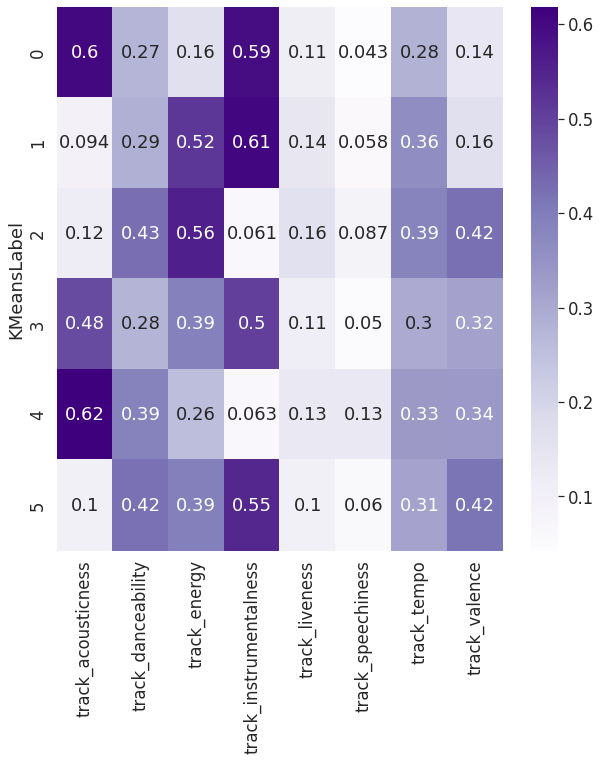

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(
    data=clusters.loc[clusters.method=='KMeans', audio_cols],
    cmap='Purples',
    annot=True
)
plt.ylabel("KMeansLabel")
plt.savefig('heatmap_all.png')

#### Clusters meaning(important)
One of the main purposes of this project is to see if clustering provides any sort of meaning behind any existing structure within the data. Given the cluster centroids from K-means, we can see the values which characterize each K-Means Label. From eyeballing the values and heatmap, we describe these clusters based on the meaning behind each feature.



- **KM0**: Highly acoustic and instrumental. Low danceability, energy tempo, valence. "Somber"

- **KM1**: High instrumental and energy. mid-tempo and low valence. "Angry"

- **KM2**: High energy, danceability, tempo and valence . "Happy"

- **KM3**: Highly instrumental and accousticness. Mid-tempo, mid-energy.  "Cheerful Instrumental"

- **KM4**: Highly accousticness. Mid-tempo, mid-energy, low instrumental.  "Cheerful Vocal"

- **KM5**: High energy, danceability, tempo, valence and instrumental . "Exciting"


Moreover, we can see how these clusters relate to each genre below. 

In [ ]:
### Assign K-Means Label to Descriptive Labels
descriptive_labels = ["Sober", "Angry", "Happy","Cheerful Instrumental",
                     "Cheerful Vocals", "Exciting"]
unique_labels = np.unique(labels)
translated_labels = dict(zip(unique_labels, descriptive_labels))
tracks['KMeansLabel'] = list(map(lambda x:translated_labels[x], labels))

genre_count = tracks.groupby('track_genretop').agg({'track_genretop':'count'})['track_genretop']

# How many instances of each k-means cluster are there?
print("### Instances of KMeans Cluster ###")
print(tracks[['track_genretop', 'KMeansLabel']].groupby('KMeansLabel').agg('count'))

# Which cluster corresponds to the most instances per genre?
print("### Which cluster corresponds to the most instances per genre? ###")
print(tracks[['track_genretop', 'KMeansLabel']].groupby('track_genretop').agg(lambda x:x.value_counts().index[0]))

# Which genre corresponds to the most instances per cluster?
print("### Which genre corresponds to the most instances per cluster? ###")
print(tracks[['track_genretop', 'KMeansLabel']].groupby('KMeansLabel').agg(lambda x:x.value_counts().index[0]))

### Instances of KMeans Cluster ###
                       track_genretop
KMeansLabel                          
Angry                            1491
Cheerful Instrumental            2169
Cheerful Vocals                  1116
Exciting                         1490
Happy                            1255
Sober                            1691
### Which cluster corresponds to the most instances per genre? ###
                                                              KMeansLabel
track_genretop                                                           
Electronic                                                       Exciting
Experimental                                                     Exciting
Folk/Old-Time / Historic                                            Sober
Hip-Hop/Blues/Classical/Country/Instrumental/In...        Cheerful Vocals
Pop                                                                 Happy
Rock                                                Cheerful Instrumental
#

There are some interesting conclusions that match up with  musical intuition. 

In cell 2, The most predominant KMeans Label for Classical, Folk and Jazz/Old time are Slow & Somber Acoustics. In contrast, the most predominant KMeans Label for Hip-hop are Upbeat Songs With Cheerful Songs, which make sense. The most predominant KMeans Label for pop and International are Happy&Slow, while The most predominant KMeans Label for Electronic and Experimental are Happy & Danceable Instrumentals. 


In cell 3, we see Rock almost dominate KMeans Labels. Because Rock has the largest sample size and different types. Besides, Electronic 
has been popular since it has fast/happy&danceabel traits. 

#### Evaluating K-Means with different metrics
Because clustering can be highly subjective, it's difficult to test the accuracy of the model.  Another approach is by calculating various metrics, as down below. The mathematical formulation can be found in sklearn's (clustering evaluation)[http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation] section. Here are ways to interpret the scores:
- **Adjusted Rand Score**: Bounded [-1,1] where 1 represents perfect label, and a score near or below 0 have independent, or "bad" labelings. 
- **Adjusted Mutual Info Score**: Bounded [0,1] where 1 represents perfect label, and a score nea0 have independent, or "bad" labelings
- **V Measure Score**: Bounded [0,1] scores: 0.0 is as bad as it can be, 1.0 is a perfect score.
- **Silhouette Score**: The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

In [ ]:
 y_true = tracks['track_genretop']
 y_pred = tracks['KMeansLabel']
 metrics = {'adjusted_rand_score':adjusted_rand_score, 
            'adjusted_mutual_info_score':adjusted_mutual_info_score, 
            'v_measure_score':v_measure_score
           }
scores = dict(zip(metrics.keys(), [metrics[m](y_true, y_pred) for m in metrics.keys()]))
scores['silhouette_score'] = silhouette_score(X,y_pred)
 for k,v in scores.items():
     print("Metric: {} Score: {}".format(k, v))

Metric: adjusted_rand_score Score: 0.04063591655550325
Metric: adjusted_mutual_info_score Score: 0.05005618556668754
Metric: v_measure_score Score: 0.05084415485057639
Metric: silhouette_score Score: 0.21520518308112158


When comparing the K-Means Labels with the actual genres, the clustering model performed poorly. Therefore we decided not to take this approach.


#### Evaluating K-Means Visually(PCA)
X has n_features = n_dimensions = 6, the clustering model can't be plotted as is. Before plugging everything into seaborn, we perform PCA through FeatureAgglomeration in order to reduce the dimensions from 6 to 2. This process effectively takes related features and merges them into different axes. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
x,y = zip(*X_new)
tracks['x'] = x
tracks['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [ ]:
audio_components = dict(list(zip(audio_cols, zip(*np.round(components,2)))))
audio_components


{'track_acousticness': (0.77, -0.36),
 'track_danceability': (-0.15, -0.17),
 'track_energy': (-0.48, 0.09),
 'track_instrumentalness': (0.25, 0.85),
 'track_liveness': (-0.04, -0.03),
 'track_speechiness': (-0.02, -0.1),
 'track_tempo': (-0.11, -0.02),
 'track_valence': (-0.26, -0.3)}

In [ ]:
components

array([[ 0.77463979, -0.14917753, -0.48214848,  0.25369987, -0.03714948,
        -0.02188932, -0.10790248, -0.25951169],
       [-0.36269854, -0.17102823,  0.09251674,  0.8539498 , -0.02793809,
        -0.10039408, -0.02105539, -0.30017773]])

In [ ]:
singular_values

array([28.34626867, 24.54541851])

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Clustering by Genre, Reduced Dimension')

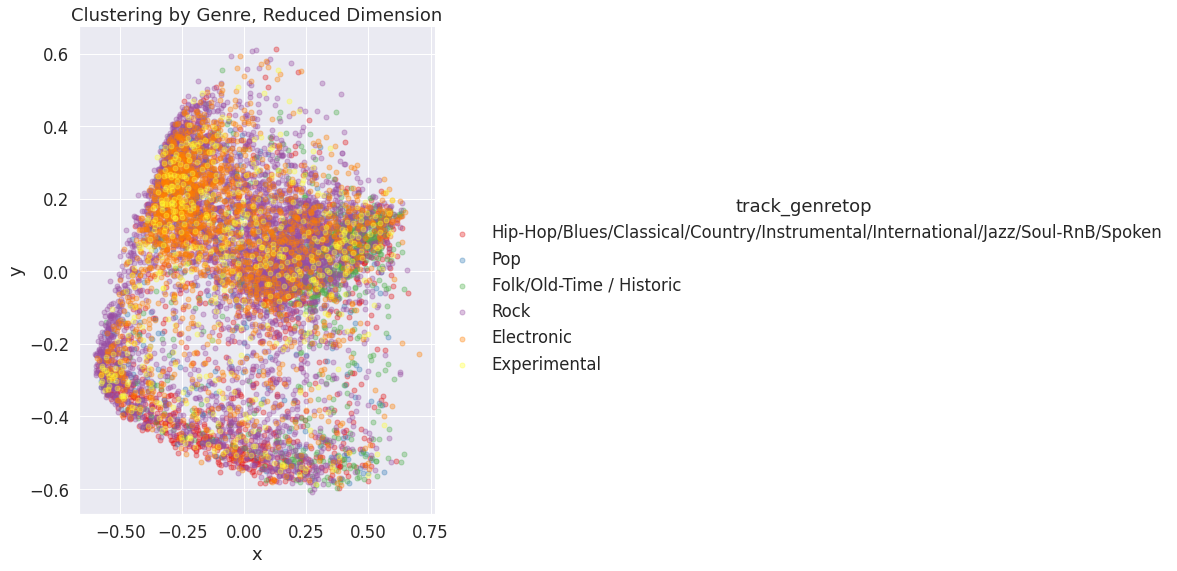

In [ ]:
sns.set(font_scale=1.5)
sns.lmplot(data=tracks, x='x', y='y', hue='track_genretop', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
# plt.legend(loc='lower right')
# plt.ylim(-0.7,1.8)
# plt.xlim(-0.7,1.8)
plt.savefig('pca_scatter_genres.png')
plt.title("Clustering by Genre, Reduced Dimension")
# arrow = plt.arrow(x=0.2, y=-0.40, dx=0.4, dy=0, width=0.04, label='More acoustic, less energy')
# arrow.label = 'More acoustic, less energy'

The dataset tends to be relatively unstructured by genre, save for a few clusters. This explains why our metrics performed poorly. There are some visual groupings, such as classical music being close to one another, and electronic music being grouped from y=0-0.15 and x=0.3-0.4. 

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


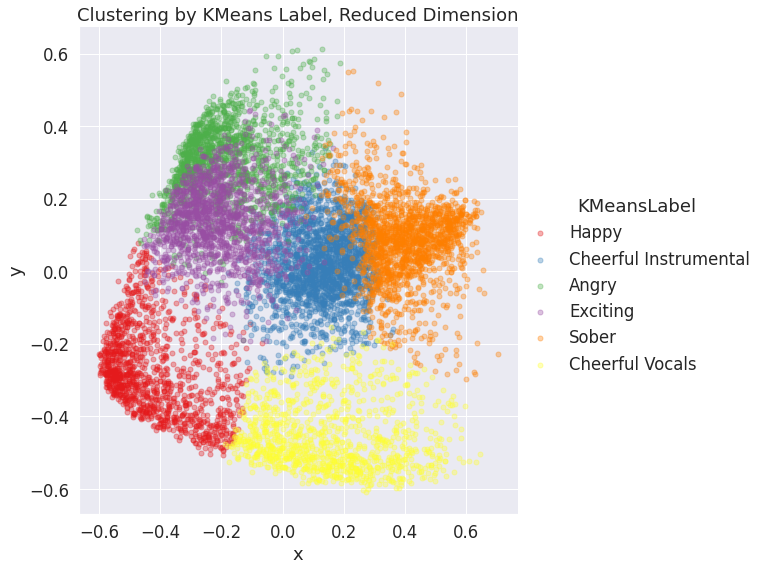

In [ ]:
sns.set(font_scale=1.5)

sns.lmplot(data=tracks, x='x', y='y', hue='KMeansLabel', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by KMeans Label, Reduced Dimension")

plt.savefig('pca_scatter_KM.png')

In [ ]:
tracks.head()

,track_title,album_date_released,album_listens,album_favorites,artist_favorites,track_genretop,track_favorites,track_listens,track_interest,track_acousticness,track_danceability,track_energy,track_instrumentalness,track_liveness,track_speechiness,track_tempo,track_valence,KMeansLabel,x,y
track_id,,,,,,,,,,,,,,,,,,,,
1,Food,1/5/2009 0:00,6073,4,9.0,Hip-Hop/Blues/Classical/Country/Instrumental/I...,2,1293,4656,0.307243,0.498383,0.467843,0.007837,0.130991,0.117470,0.475934,0.425212,Happy,-0.257914,-0.413370
2,Electric Ave,1/5/2009 0:00,6073,4,9.0,Hip-Hop/Blues/Classical/Country/Instrumental/I...,1,514,1470,0.294483,0.415794,0.642959,0.001456,0.083278,0.363234,0.378520,0.211766,Happy,-0.279233,-0.341082
3,This World,1/5/2009 0:00,6073,4,9.0,Hip-Hop/Blues/Classical/Country/Instrumental/I...,6,1151,1933,0.033152,0.567331,0.533777,0.000530,0.283940,0.094810,0.280598,0.473047,Happy,-0.510688,-0.338133
4,Freeway,2/6/2008 0:00,47632,4,74.0,Pop,178,50135,54881,0.462064,0.319566,0.448885,0.468744,0.056066,0.016015,0.202164,0.467852,Cheerful Instrumental,0.038244,-0.041859
5,Street Music,1/5/2009 0:00,6073,4,9.0,Hip-Hop/Blues/Classical/Country/Instrumental/I...,3,943,1126,0.315820,0.358436,0.391380,0.013578,0.067440,0.367013,0.298819,0.624403,Happy,-0.227753,-0.474057


In [ ]:
tracks.rename({'track_genretop':'MainGenre'}, axis=1).to_csv('tracks_with_kmeans.csv')
#tracks.

In [ ]:
from google.colab import files
files.download("tracks_with_kmeans.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion
### Genre Clustering Shows Structure Differently Than Genres Themselves
Due to the subjective nature of clustering, and the variable nature of music, it's difficult to decisively grade the model's performance. Various clustering algorithms were able to find structure, just not the same messy structure that is estimated by our subjective listening experience. However, this makes for interesting cross-genre similarities. A user who listens to mostly, say Classical, may discover Folk/Blues songs he/she likes that otherwise wouldn't be discovered if music recommendation engines drew the line within boundaries.  Where songs are divided into genres, audio feature groupings tend to cross. 

### Intuitive Pairings
The clusters from the features do suggest interesting and intuitive relationships between genres. A punk fan will agree that punk tends to be fast and energetic, and a psych-rock fan will agree that psych-rock is slow and depressing.

### Future Work
The main constraints of this analysis are the following:
- usage of a relatively small (13000 tracks) and limited dataset. Perhaps using Spotify's API to gather more music data would allow the data to build a semblance of structure. 
- Spotify's features constrained the music to be described in 8 different ways. Maybe using more descriptive features as the ones used could illuminate some of the key distinctions between genres. 